In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy import stats

1.Construct a linear regression of weight as predicted by height, using the adults (age 18 or greater) from the Howell1 dataset. The heights listed below were recorded in the !Kung census, but weights were not recorded for these individuals. Provide predicted weights and 89% compatibility intervals for each of these individuals. That is, fill in the table below, using model-based predictions.


<div>
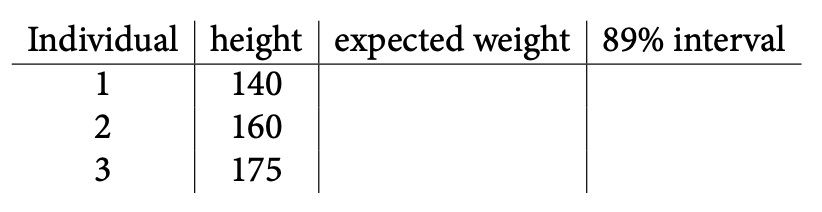
</div>

In [2]:
howell_path = '/Users/amralaa/CS - AGI core/[Prereq] Statistical Rethinking/resources/Rethinking_2/Data/Howell1.csv'

In [3]:
d = pd.read_csv(howell_path, delimiter = ';')

Statistical Description of the model:

$$ W = f(H)$$

$$ W_i \text{~} N(\mu_i, \sigma)$$

$$ \mu_i = \alpha + \beta (H - bar{H})$$

$$ \alpha \text{~} N(60,20)$$

$$ \beta \text{~} LogNorm(0,1)$$

$$ \sigma \text{~} Uniform(0,50)$$

In [4]:
#adults only
d2 = d[d['age']>=18]
d2.age.min()

18.0

In [5]:
#now in code

with pm.Model() as m1:
    alpha = pm.Normal('alpha', mu = 60, sd = 20)
    beta = pm.Lognormal('beta', mu = 0, sd = 1)
    mu = alpha + beta * (d2.height - d2.height.mean())
    sigma = pm.Uniform('sigma', lower = 0, upper = 50)
    w = pm.Normal('w', mu = mu, sd = sigma, observed = d2.weight)
    
    trace_m1 = pm.sample(1000, tune = 1000)

/var/folders/9p/5ycxgmps44zc3f0y6vljhp2h0000gn/T/ipykernel_32001/1520291127.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_m1 = pm.sample(1000, tune = 1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


In [6]:
# let's get alpha and beta parameters that we'll use to create mu for the heights provided
trace_df = pm.trace_to_dataframe(trace_m1, varnames = ['alpha','beta'])
trace_df.head()

,alpha,beta
0,45.117976,0.596792
1,45.113723,0.588078
2,45.294565,0.654811
3,44.793509,0.601210
4,45.186117,0.613408


In [7]:
# generate 1000 samples
sample_params = trace_df.sample(axis = 0, n = 1000)

In [8]:
sample_params.shape

(1000, 2)

In [9]:
sample_params.head()

,alpha,beta
480,44.609860,0.632474
624,44.909476,0.596060
1766,45.125100,0.626535
2388,44.912682,0.669302
3355,44.708831,0.631801


In [10]:
# now calculate expected weights and 89% hdi
heights = np.array([140,160,174])

In [11]:
heights - d2.height.mean()

array([-14.59709261,   5.40290739,  19.40290739])

In [12]:
mu140 = sample_params.alpha + sample_params.beta * (140 - d2.height.mean())
mu160 = sample_params.alpha + sample_params.beta * (160 - d2.height.mean())
mu174 = sample_params.alpha + sample_params.beta * (174 - d2.height.mean())

In [13]:
mean_mu140 = np.mean(mu140)
mean_mu160 = np.mean(mu160)
mean_mu174 = np.mean(mu174)

In [14]:
hdi140 = az.hdi(np.array(mu140))
hdi160 = az.hdi(np.array(mu160))
hdi174 = az.hdi(np.array(mu174))

In [15]:
res = pd.DataFrame({'height':[140,160,174],
                   'expected weight':[mean_mu140,mean_mu160,mean_mu174],
                   '94% HDI':[hdi140,hdi160,hdi174]})

In [16]:
res

,height,expected weight,94% HDI
0,140,35.847563,"[34.89990242854645, 36.76470918873015]"
1,160,48.393551,"[47.91093872197885, 48.92310649793456]"
2,174,57.175742,"[55.986811416393486, 58.3106354305116]"


2.From the Howell1 dataset,consider only the people younger than 13 years old. Estimate the causal association between age and weight. Assume that age influences weight through two paths. First, age influences height, and height influences weight. Second, age directly influences weight through age- related changes in muscle growth and body proportions. All of this implies this causal model (DAG):

<div>
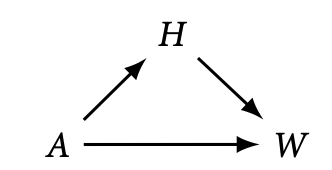
</div>


Use a linear regression to estimate the total (not just direct) causal effect of each year of growth on weight. Be sure to carefully consider the priors. Try using prior predictive simulation to assess what they imply.

In [17]:
d3 = d[d['age']<13]

In [18]:
d3.age.max()

12.0

Text(0.5, 1.0, 'Age < 13')

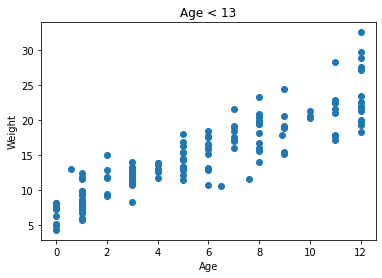

In [19]:
plt.scatter(d3.age,d3.weight);
plt.xlabel('Age');
plt.ylabel('Weight');
plt.title('Age < 13')

Let's try some inital values for priors and plot their predectives. Our model will look like:

$W = f(A)$

$W_i \text{~} N(\mu_i,\sigma)$

$\mu_i = \alpha + \beta A_i$

$\alpha \text{~} N(10,5)$

$\beta \text{~} LogNorm(0,1)$

$\sigma \text{~} Unif(0,30)$

In [20]:
# let's plot the predictions of priors
n = 100

alpha = np.random.normal(loc = 10, scale = 5, size = n)
beta = np.random.lognormal(mean = 0, sigma = 1, size = n)
sigma = np.random.uniform(0,30,n)
mu = alpha + beta * np.linspace(1.5,40,n)
weight_sample = np.random.normal(mu,sigma)

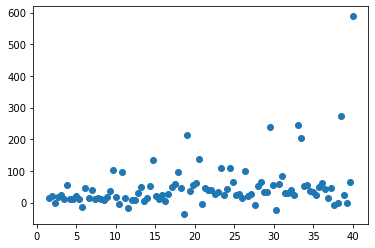

In [21]:
plt.scatter(np.linspace(1.5,40,n),weight_sample);

In [22]:
# let's run this model

with pm.Model() as m2:
    alpha = pm.Normal('alpha', mu = 10, sd = 5)
    beta = pm.Lognormal('beta', mu = 0, sd = 1)
    mu = pm.Deterministic('mu',alpha + beta * d3.age)
    sigma = pm.Uniform('sigma', lower = 0, upper = 50)
    w = pm.Normal('w', mu = mu, sd = sigma, observed = d3.weight)
    
    trace_m2 = pm.sample(1000, tune = 1000)

/var/folders/9p/5ycxgmps44zc3f0y6vljhp2h0000gn/T/ipykernel_32001/3278225893.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_m2 = pm.sample(1000, tune = 1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.8813089868988575, but shou

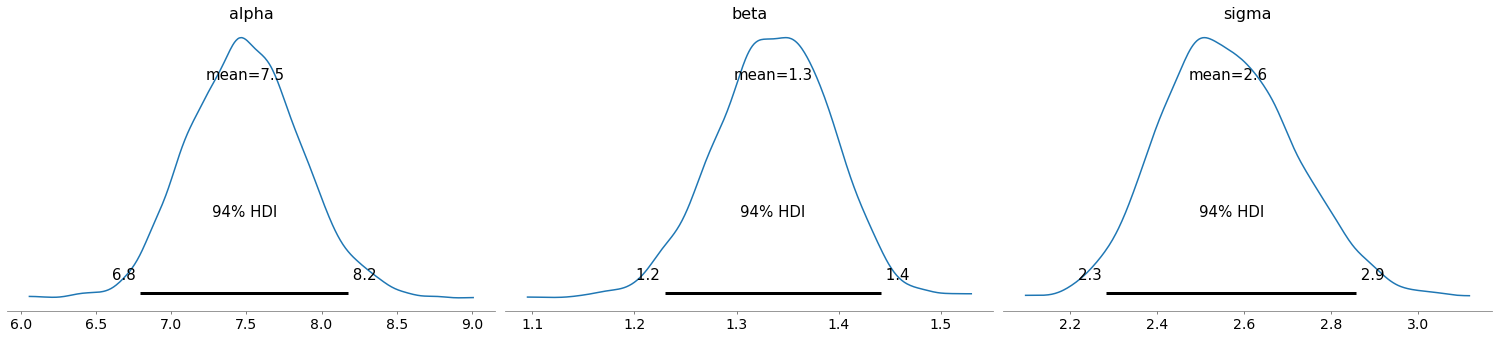

In [23]:
with m2:
    az.plot_posterior(trace_m2,var_names = ['alpha', 'beta', 'sigma'])

The causal effect is given by the $\beta$ parameter, here has a range of 1.2 - 1.4 kilograms for every year of growth.

In [24]:
#let's try the ECDF (as per Eric Ma): https://github.com/ericmjl/bayesian-stats-modelling-tutorial/blob/master/notebooks/01a-instructor-probability-simulation.ipynb

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points
    n = len(data)

    # x-data for the ECDF
    x = np.sort(data)

    # y-data for the ECDF
    y = np.arange(1, n+1) / n

    return x, y

In [25]:
# get posterior predective sample
pps = pm.sample_posterior_predictive(trace_m2,d3.weight.shape[0],m2)

/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [26]:
# plot sample agaist pps
xd3,yd3 = ecdf(d3.weight)
xm2,ym2 = ecdf(pps['w'].mean(0))

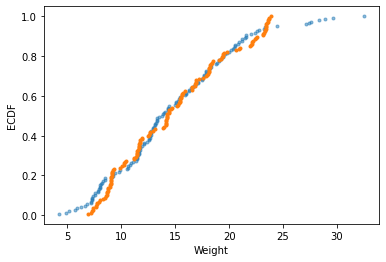

In [27]:
plt.plot(xd3,yd3,marker='.', linestyle='none', alpha = 0.5);
plt.plot(xm2,ym2,marker='.', linestyle='none');
plt.xlabel('Weight');
plt.ylabel('ECDF');

Looks like the model is able to produce data similar to our sample.

In [28]:
trace_m2['mu'].shape

(4000, 146)

/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


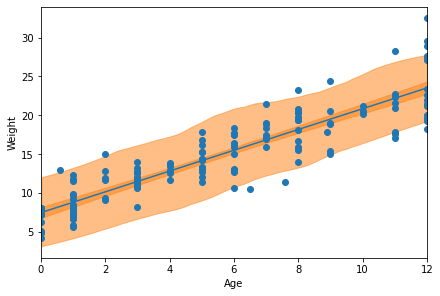

In [29]:
ax = az.plot_hdi(d3.age,pps['w']);
az.plot_hdi(d3.age,trace_m2['mu']);
plt.scatter(d3.age,d3.weight);
plt.plot(d3.age,trace_m2['mu'].mean(0));
plt.xlim(d3.age.min(),d3.age.max());
plt.xlabel('Age');
plt.ylabel('Weight');

The model seems to be able to capture the center and the uncertainty of our data (except at the right edge of 12 years old). This might be due to Biological reasons that this is when puberty occurs and thus the growth spurts - which some reach before others - lead to such wide dispersion of weights (and I'm thinking heights as well).

3.Now suppose the causal association between age and weight might be different for boys and girls. Use a single linear regression, with a categorical variable for sex, to estimate the total causal effect of age on weight separately for boys and girls. How do girls and boys differ? Provide one or more posterior contrasts as a summary.

In the data, M = 1, F = 0

In [30]:
index_var = d3.male.values

In [60]:
with pm.Model() as m3:
    sigma = pm.Uniform('sigma', 0, 50)
    
    alpha = pm.Normal('alpha', mu = 10, sd = 5, shape = (2,))
    beta = pm.Lognormal('beta', mu = 0, sd = 1, shape = (2,))
    
    mu = pm.Deterministic('mu', alpha[index_var] + beta[index_var]*d3.age)
    
    #get the difference between males - females
    diff = pm.Deterministic("diff", mu[1] - mu[0])
    
    w = pm.Normal('w', mu = mu, sd = sigma, observed = d3.weight)
    trace_m3 = pm.sample(1000, tune = 1000)

/var/folders/9p/5ycxgmps44zc3f0y6vljhp2h0000gn/T/ipykernel_32001/2482503701.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_m3 = pm.sample(1000, tune = 1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, sigma]


/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [61]:
varnames = ['alpha','beta','sigma']

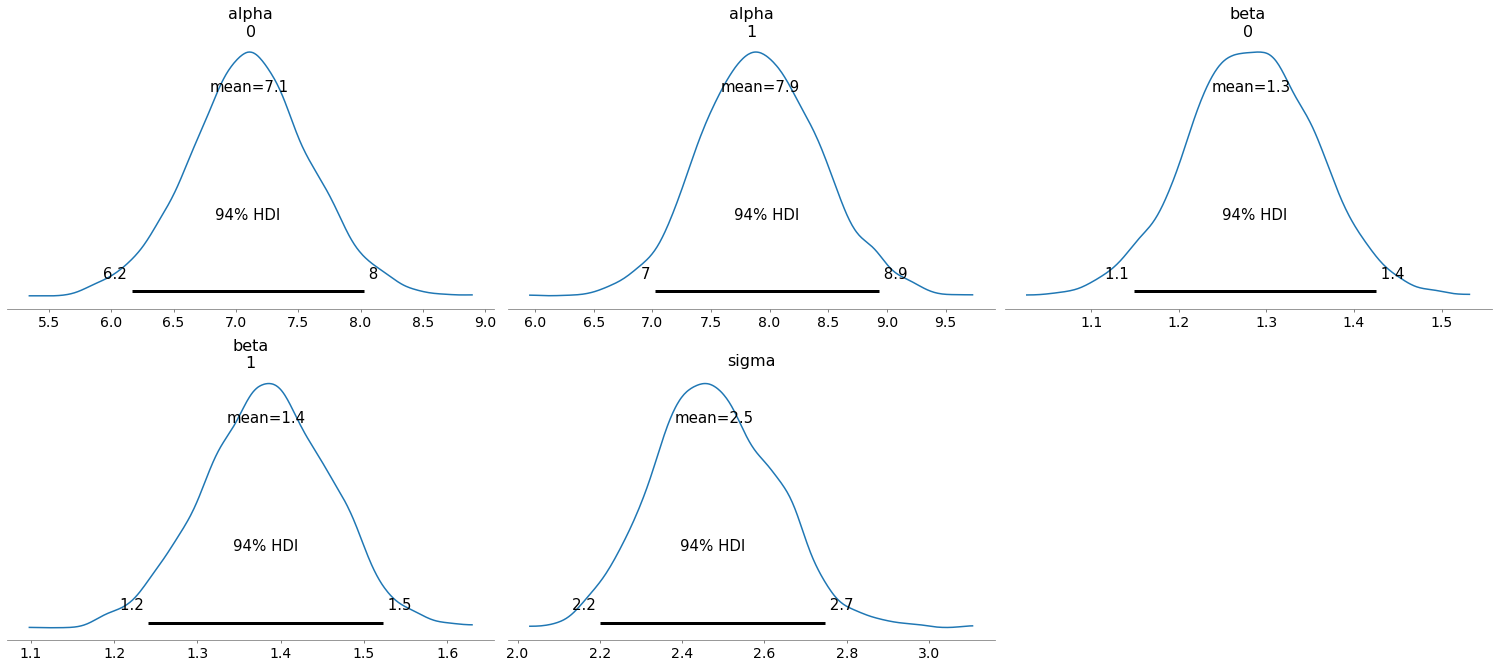

In [62]:
with m3:
    az.plot_posterior(trace_m3,var_names = varnames)

In [63]:
with m3:
    print(az.summary(trace_m3,var_names = varnames))

           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha[0]  7.109  0.489   6.163    8.025      0.010    0.007    2620.0   
alpha[1]  7.923  0.511   7.021    8.933      0.010    0.007    2372.0   
beta[0]   1.283  0.074   1.149    1.425      0.001    0.001    2600.0   
beta[1]   1.383  0.076   1.241    1.523      0.002    0.001    2427.0   
sigma     2.478  0.149   2.201    2.748      0.003    0.002    2849.0   

          ess_tail  r_hat  
alpha[0]    2766.0    1.0  
alpha[1]    2433.0    1.0  
beta[0]     2441.0    1.0  
beta[1]     2217.0    1.0  
sigma       2351.0    1.0  


In [71]:
az.summary(trace_m3, var_names = varnames)

/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],7.109,0.489,6.163,8.025,0.010,0.007,2620.0,2766.0,1.0
alpha[1],7.923,0.511,7.021,8.933,0.010,0.007,2372.0,2433.0,1.0
beta[0],1.283,0.074,1.149,1.425,0.001,0.001,2600.0,2441.0,1.0
beta[1],1.383,0.076,1.241,1.523,0.002,0.001,2427.0,2217.0,1.0
sigma,2.478,0.149,2.201,2.748,0.003,0.002,2849.0,2351.0,1.0


In [65]:
#let's get the mu for boys and girls separately
male_mu = trace_m3['mu'][:,d3.male.values==1]
female_mu = trace_m3['mu'][:,d3.male.values==0]

In [66]:
male_mu.shape, female_mu.shape

((4000, 71), (4000, 75))

/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


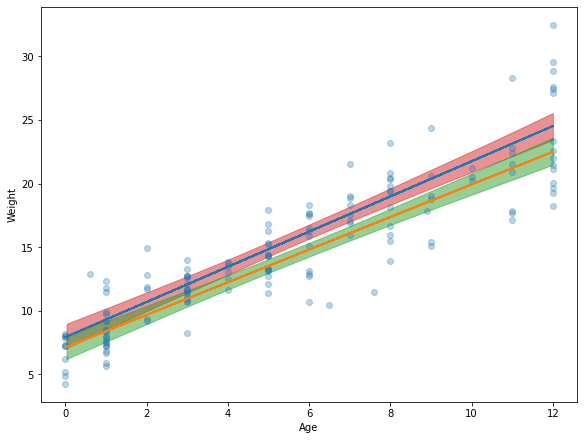

In [82]:
ax = az.plot_hdi(d3.age[d3.male == 1],male_mu, color = 'C3', figsize = (8,6));#C3 is red
az.plot_hdi(d3.age[d3.male == 0],female_mu, color = 'C2', ax=ax); #C2 is green
plt.plot(d3.age[d3.male == 1], male_mu.mean(0));
plt.plot(d3.age[d3.male == 0], female_mu.mean(0));
plt.scatter(d3.age, d3.weight, alpha = 0.3);
plt.xlabel('Age');
plt.ylabel('Weight');

In [68]:
male_mu.mean(), female_mu.mean()

(15.52248017793353, 13.923880276798336)

In [57]:
d3.groupby('male').weight.describe()

,count,mean,std,min,25%,50%,75%,max
male,,,,,,,,
0,75.0,13.913935,5.452293,4.252425,9.851451,13.267566,17.364069,29.596878
1,71.0,15.516631,5.922350,5.669900,11.467373,14.401546,19.050864,32.488527


In [84]:
trace_m3['sigma'].shape

(4000,)

The model shows that males are heavier on average than females in this sample and they also grow faster (slope).

We're interested in the expected difference between males and females. We'll compute this by sampling from the posterior and subtracting samples from one another.

In [112]:
'''
Here I decided to do things manually since I didn't know how to do it with pymc3.
I first decided I'll sample 100 weights for each sex
I randomly picked 100 alphas and betas for each sex
Then I computed the mu for each sex using these sampled alphas and betas
Then used the generated mu(s) inside a normal dist for each sex
I subtracted both values and plotted the histogram of the difference
'''
n = 100
alpha_m = np.random.choice(trace_m3['alpha'][:,1],n)
alpha_f = np.random.choice(trace_m3['alpha'][:,0],n)
beta_m = np.random.choice(trace_m3['beta'][:,1],n)
beta_f = np.random.choice(trace_m3['beta'][:,0],n)

In [118]:
sigma_s = np.random.choice(trace_m3['sigma'],n)

In [113]:
ages = np.linspace(0,12,n)

In [122]:
pred_mu_m = alpha_m + beta_m * ages
pred_mu_f = alpha_f + beta_f * ages

In [123]:
ppw_m = np.random.normal(loc = pred_mu_m,scale = sigma_s)
ppw_f = np.random.normal(loc = pred_mu_f,scale = sigma_s)

In [127]:
diff_mf = ppw_m - ppw_f

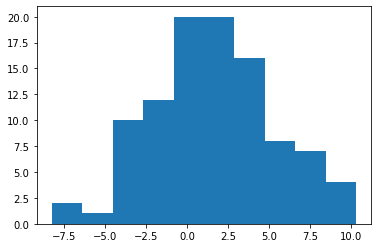

In [133]:
plt.hist(diff_mf);

This distribution is the difference Males - Females. So, looks like males are  heavier (more values > 0) , however, there are also some females that are heavier than males (the < 0) which is expected anyway as with any population (males will be havier on average but on an idividual level, there will be females heavier than males).

4 - OPTIONAL CHALLENGE. The data in data(Oxboys) (rethinking package) are growth records for 26 boys measured over 9 periods. I want you to model their growth. Specifically, model the increments in growth from one period (Occasion in the data table) to the next. Each increment is simply the difference between height in one occasion and height in the pre- vious occasion. Since none of these boys shrunk during the study, all of the growth increments are greater than zero. Estimate the posterior distribution of these increments. Constrain the distribution so it is always positive—it should not be possible for the model to think that boys can shrink from year to year. Finally compute the posterior distribution of the total growth over all 9 occasions.